In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta
import sqlite3 as sqlite
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
%matplotlib inline

/Users/dmalav/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<h1>Data Collection</h1>
<h3>US GDP Data</h3>

In [2]:
gdp_data = pd.read_csv('../data/gdp.csv', sep = '\t')
gdp_data.head()

,quarter,gdp_current,gdp_chained
0,1947q1,243.1,1934.5
1,1947q2,246.3,1932.3
2,1947q3,250.1,1930.3
3,1947q4,260.3,1960.7
4,1948q1,266.2,1989.5


In [3]:
def quarter_to_date(quarter):
    year = quarter[:-2]
    q = quarter[-2:]
    if q == 'q1':
        return (datetime(year=int(year), month=1, day=1).date(), 
                datetime(year=int(year), month=3, day=31).date())
    elif q == 'q2':
        return (datetime(year=int(year), month=4, day=1).date(),
                datetime(year=int(year), month=6, day=30).date())
    elif q == 'q3':
        return (datetime(year=int(year), month=7, day=1).date(), 
                datetime(year=int(year), month=9, day=30).date())
    elif q == 'q4':
        return (datetime(year=int(year), month=10, day=1).date(), 
                datetime(year=int(year), month=12, day=31).date())

In [4]:
gdp_data['start_date'] = gdp_data['quarter'].apply(lambda x: quarter_to_date(x)[0])
gdp_data['end_date'] = gdp_data['quarter'].apply(lambda x: quarter_to_date(x)[0])
gdp_data.head()

,quarter,gdp_current,gdp_chained,start_date,end_date
0,1947q1,243.1,1934.5,1947-01-01,1947-01-01
1,1947q2,246.3,1932.3,1947-04-01,1947-04-01
2,1947q3,250.1,1930.3,1947-07-01,1947-07-01
3,1947q4,260.3,1960.7,1947-10-01,1947-10-01
4,1948q1,266.2,1989.5,1948-01-01,1948-01-01


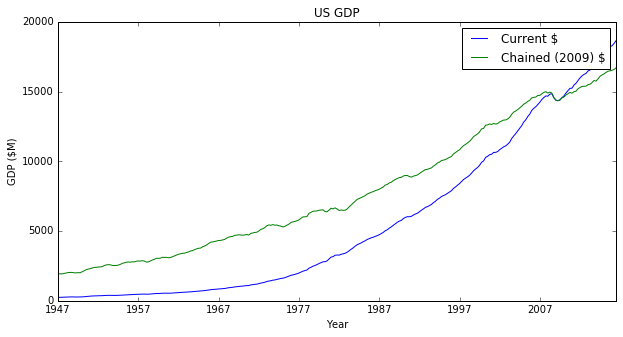

In [5]:
plt.figure(figsize=(10,5))
plt.title('US GDP')
plt.plot(gdp_data['end_date'].values, gdp_data['gdp_current'].values, label='Current $')
plt.plot(gdp_data['end_date'].values, gdp_data['gdp_chained'].values, label='Chained (2009) $')
plt.xlabel('Year')
plt.ylabel('GDP ($M)')
plt.legend()
plt.show()

In [6]:
gdp_data['rate'] = gdp_data['gdp_chained'].pct_change(1)
gdp_data['sentiment'] = gdp_data['rate'].apply(lambda x : 'pos' if x > 0 else 'neg')
gdp_data['rate_slope'] = gdp_data['rate'].pct_change(1)
gdp_data['sentiment2'] = gdp_data['rate_slope'].apply(lambda x : 'pos' if x > 0 else 'neg')

gdp_data.head()

,quarter,gdp_current,gdp_chained,start_date,end_date,rate,sentiment,rate_slope,sentiment2
0,1947q1,243.1,1934.5,1947-01-01,1947-01-01,NaN,neg,NaN,neg
1,1947q2,246.3,1932.3,1947-04-01,1947-04-01,-0.001137,neg,NaN,neg
2,1947q3,250.1,1930.3,1947-07-01,1947-07-01,-0.001035,neg,-0.089874,neg
3,1947q4,260.3,1960.7,1947-10-01,1947-10-01,0.015749,pos,-16.215749,neg
4,1948q1,266.2,1989.5,1948-01-01,1948-01-01,0.014689,pos,-0.067320,neg


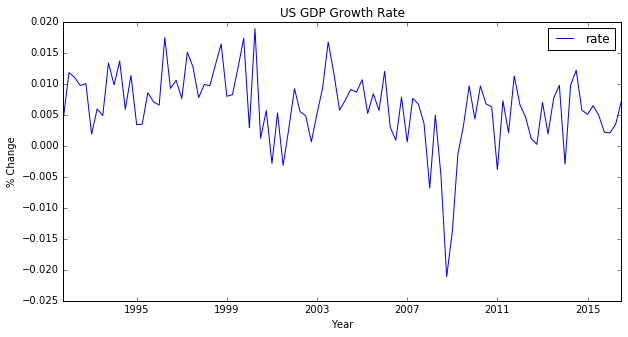

In [8]:
plt.figure(figsize=(10,5))
plt.title('US GDP Growth Rate')
plt.plot(gdp_data['end_date'].iloc[-100:], gdp_data['rate'].iloc[-100:])
# plt.plot(gdp_data['end_date'].iloc[-100:], gdp_data['rate_slope'].iloc[-100:])
plt.xlabel('Year')
plt.ylabel('% Change')
plt.legend()
plt.show()

In [9]:
gdp_data.to_csv('response.csv', index=False)

<h3>New Article Data Collection</h3>
The New York Times (NYT) provides an Article Search API to fetch data related to news articles. This API does not return full text of articles, but it will return a number of helpful metadata such as subject terms, abstract, lead paragraph, and date, as well as URLs, which one could conceivably use to scrape the full text of articles. For this project we will be collecting lead paragraph for business articles for specified time period.
In order to request data from NYT an API key must be requested from http://developer.nytimes.com/. The article search API is limited to 1K calls per day, and 5 calls per second. These limits impose challenge for collecting as much data as possible for a day and time period. Based on the limited time for the project, the data collection was limited to two API calls or 20 article per day. This allowed to request 500 days worth of data per day.
A python wrapper was developed around NYT Article Search API to get articles for a given start and end date. The reqested lead paragraph data are then store in a file with file name reflecting the day in the format YYYYMMDD.txt

In [10]:
# Data collection using NYTimes API
class NYTArticlesApi(object):
    def __init__(self, api_key):
        self.api_key = api_key
        self.url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json'

    def request_articles(self, start_date, end_date, page):
        start_date_str = start_date.strftime('%Y%m%d')
        end_date_str = end_date.strftime('%Y%m%d')

        params = {
            'api-key': self.api_key,
            'fq': "section_name:Business",
            'begin_date': start_date_str,
            'end_date': end_date_str,
            'fl': "lead_paragraph",
            'sort': "newest",
            'page': page
        }
        r = requests.get(self.url, params=params)

        if r.status_code == 200:
            response = json.loads(r.text)
            docs = response['response']['docs']
            return [item['lead_paragraph'] for item in docs]

        print "Error: api response: ", r.status_code, "Message :", r.text
        return None

    def fetch_articles(self, start_date, end_date, data_dir):
        cur_date = start_date
        while cur_date >= end_date:
            print 'Processing ', cur_date, '...'
            articles = []
            # get 2 pages for each day, i.e. 20 articles
            for page in range(2):
                articles_page = self.request_articles(cur_date, cur_date, page)
                if articles_page:
                    articles += articles_page
                else:
                    print "No data for page {0}.".format(page)
                    time.sleep(1)
                    break
                time.sleep(1)

            if len(articles) > 0:
                file_name = data_dir + cur_date.strftime('%Y%m%d') + '.txt'
                with open(file_name, 'wb',) as f:
                    for text in articles:
                        if text:
                            f.write(text.encode('utf-8').strip() + '\n')

            else:
                print "Error fetching articles for {0}.".format(cur_date)
                file_name = data_dir + "last_date.txt"
                with open(file_name, 'wb',) as f:
                    f.write(cur_date.strftime('%Y%m%d'))
                return

            cur_date -= timedelta(days=1)

In [11]:
# Class to load data in a SQLite database
class SqliteDB(object):
    def __init__(self, db_file):
        self.db_file = db_file
        self.con = sqlite.connect(db_file)
        self.cur = self.con.cursor()
    
    def close_connection(self):
        self.con.close()
        
    def create_articles_table(self):
        self.cur.execute("CREATE TABLE Articles(Day DATE, ArticleId INT, Article TEXT, UNIQUE(Day, ArticleId) ON CONFLICT REPLACE)")

    def insert_articles(self, file_name, cur_date):
        with open(file_name, 'rb',) as f:
            articles = f.readlines()

        for i, article in enumerate(articles):
            article = article.replace('\'', '')
            self.cur.execute("INSERT INTO Articles VALUES('{0}','{1}','{2}')".format(cur_date, i, article))


    def insert_data(self, data_dir, start_date, end_date):
        print start_date, end_date
        cur_date = start_date
        while cur_date >= end_date:
            cur_date_str = cur_date.strftime('%Y-%m-%d')
            print cur_date_str
            file_name = data_dir + cur_date.strftime('%Y%m%d') + '.txt'
            # print file_name
            if os.path.exists(file_name):
                self.insert_articles(file_name, cur_date_str)

            cur_date -= timedelta(days=1)
        
        self.con.commit()
            
    def query_data(self, query):
        df = pd.read_sql(query, self.con)
        return df;


<h1>Loading and tokenizing data</h1>

In [12]:
def load_data(data_dir, start_date, end_date):
    data = {}
    cur_date = start_date
    while cur_date >= end_date:
        file_name = data_dir + cur_date.strftime('%Y%m%d') + '.txt'
        if os.path.exists(file_name):
            with open(file_name, 'rb',) as f:
                articles = f.readlines()
            data[cur_date] = " ".join(articles)

        cur_date -= timedelta(days=1)

    return data

In [13]:
db = SqliteDB('../data/articles.sqlite')
query = "SELECT strftime(\"%Y\", Day) as 'year', count(*) as 'count' FROM Articles group by strftime(\"%Y\", Day)"
df = db.query_data(query)

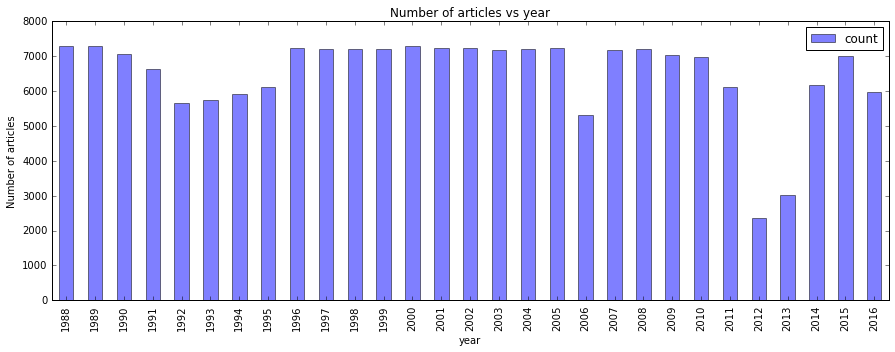

In [14]:
f, axs = plt.subplots(1,1,figsize=(15,5))
plt.title('Number of articles vs year')
plt.ylabel('Number of articles')
df.plot(kind='bar', x='year', y='count', ax=axs, alpha=0.5)
plt.show()

In [15]:
def load_words(start_date, end_date):
    data = pd.DataFrame()
    cur_date = start_date
    while cur_date <= end_date:
        next_date = cur_date + timedelta(days=30)
        query = "SELECT Day as day, Article as articles FROM Articles where Day >= '{0}' and Day <='{1}'".format(cur_date, next_date)
        df = db.query_data(query)
        df['date'] = pd.to_datetime(df['day'])
        df = df.drop('day', 1)
        df['month'] = df['date'].apply(lambda d: str(d.year) + '-' + str(d.month))
        df['quarter'] = df['date'].apply(lambda d: str(d.year) + 'q' + str((d.month-1)//3+1))
        
        data = data.append(df)

        cur_date = next_date + timedelta(days=1)
        
    return data

In [16]:
start_date = datetime(year=1988, month=1, day=1).date()
end_date = datetime(year=2016, month=10, day=31).date()

all_data = load_words(start_date, end_date)
all_data.head()

,articles,date,month,quarter
0,"LEAD: The Onset Corporation, an acquisition co...",1988-01-01,1988-1,1988q1
1,LEAD: *3*** COMPANY REPORTS ** *3*INTEGRATED G...,1988-01-01,1988-1,1988q1
2,LEAD: Orders to the nations factories edged up...,1988-01-01,1988-1,1988q1
3,LEAD: Texaco Inc. intends to borrow $3.4 billi...,1988-01-01,1988-1,1988q1
4,LEAD: INTERNATIONAL The dollar ended a bleak y...,1988-01-01,1988-1,1988q1


In [17]:
# join all articles to form single string
articles = all_data.groupby('quarter')['articles'].apply(lambda x: "".join(x))
# remove LEAD: from api text, convert to lower case
articles = articles.apply(lambda x: x.replace("LEAD:", '').lower())
articles = articles.to_frame().reset_index()
articles.head()

,quarter,articles
0,1988q1,"the onset corporation, an acquisition company..."
1,1988q2,*3*** company reports ** *3*quick & reilly gr...
2,1988q3,prime minister margaret thatcher of britain s...
3,1988q4,"delchamps inc., a regional supermarket chain ..."
4,1989q1,magazine redesigns are not aimed only at garn...


In [18]:
dataset = pd.merge(articles, gdp_data, on='quarter')
dataset.head()

,quarter,articles,gdp_current,gdp_chained,start_date,end_date,rate,sentiment,rate_slope,sentiment2
0,1988q1,"the onset corporation, an acquisition company...",5090.6,8339.3,1988-01-01,1988-01-01,0.005619,pos,-0.659665,neg
1,1988q2,*3*** company reports ** *3*quick & reilly gr...,5207.7,8449.5,1988-04-01,1988-04-01,0.013215,pos,1.351592,pos
2,1988q3,prime minister margaret thatcher of britain s...,5299.5,8498.3,1988-07-01,1988-07-01,0.005775,pos,-0.562944,neg
3,1988q4,"delchamps inc., a regional supermarket chain ...",5412.7,8610.9,1988-10-01,1988-10-01,0.013250,pos,1.294127,pos
4,1989q1,magazine redesigns are not aimed only at garn...,5527.4,8697.7,1989-01-01,1989-01-01,0.010080,pos,-0.239210,neg


In [19]:
articles['quarter'].values
print articles.shape

(116, 2)


range of post lengths: 188757 - 12221
mean of post lengths: 101383.652174


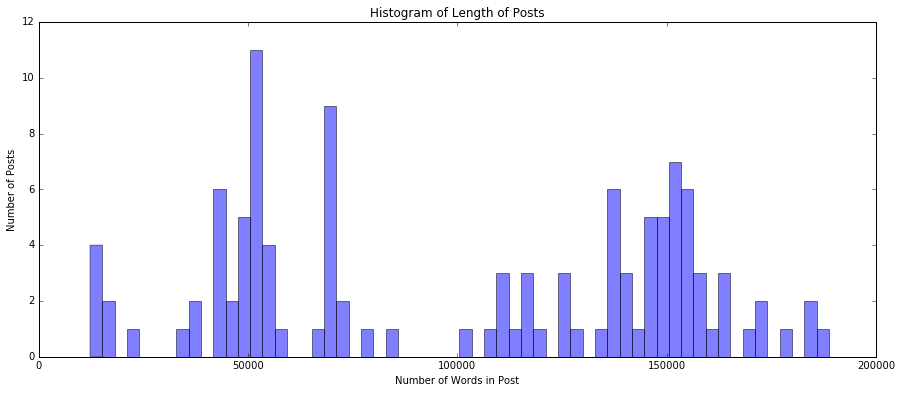

In [20]:
#Break each posts into words and count the number of words
lengths = dataset['articles'].apply(lambda x: len(x.split(' ')))

print 'range of post lengths:', np.max(lengths), '-', np.min(lengths)
print 'mean of post lengths:', np.mean(lengths)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

#Histogram of the word counts in each post
ax.hist(lengths, color='blue', bins=60, alpha=0.5)

ax.set_xlabel('Number of Words in Post')
ax.set_ylabel('Number of Posts')
ax.set_title('Histogram of Length of Posts')

plt.show()

In [21]:
#Create a text vectorizer (turns text into array of numbers)
#using a common list of English stop words

# create featureset from vectorizin text
corpus = dataset['articles']
vectorizer = CountVectorizer(stop_words='english', min_df=3, token_pattern=r'[a-z][a-z][a-z]+')

featureset = vectorizer.fit_transform(corpus)
featureset = featureset.toarray()

feature_names = vectorizer.get_feature_names()
stop_words = vectorizer.get_stop_words()
# print len(features), features
print featureset.shape

(115, 45459)


In [35]:
#Number of top words
n = 50

#Count the number of time each word occurs in the entire dataset
word_freq = featureset.sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

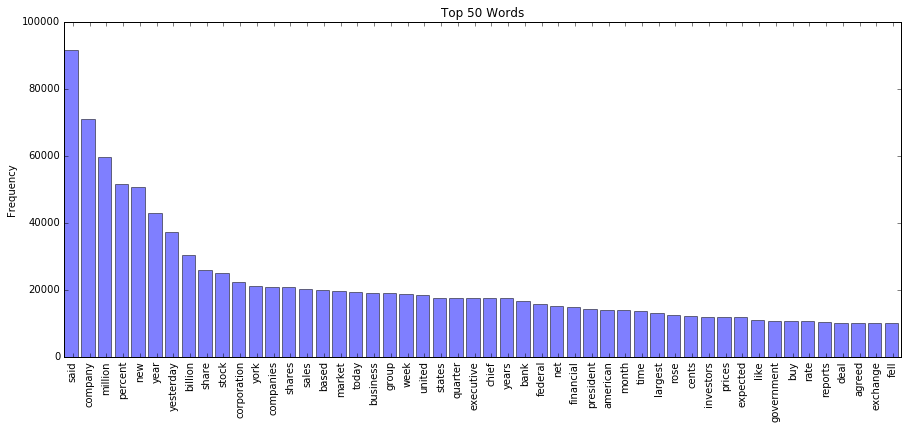

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

#Number of bars to use
indices = np.arange(n)
#Where to put the label under each bar
width = 0.5
#Bar plot of the frequencies of the top words
ax.bar(indices, [word[0] for word in top_words], color='blue', alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Top ' + str(n) + ' Words')

#Label the bars with the top words
ax.set_xticks(indices + width)
ax.set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax.get_xticklabels()
plt.setp(labels, rotation=90, fontsize=10)

plt.show()

/Users/dmalav/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/Users/dmalav/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


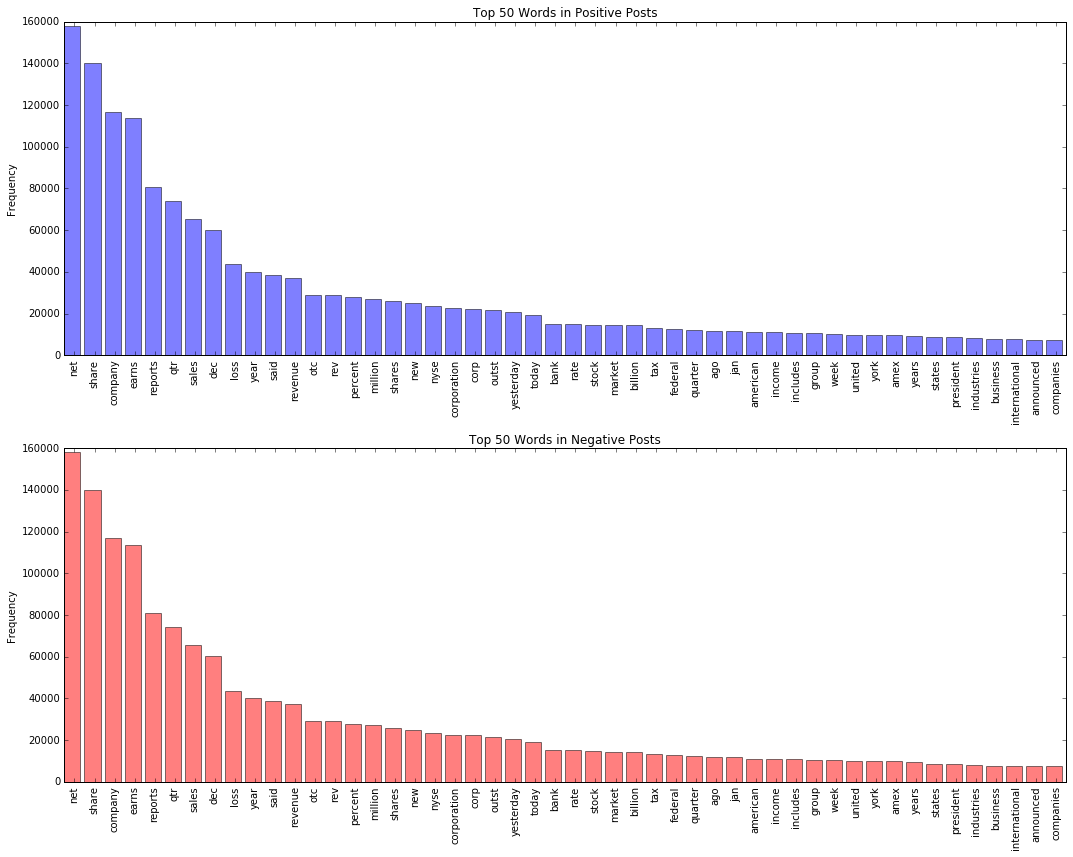

In [37]:
x = featureset
y = dataset['sentiment2']

fig, ax = plt.subplots(2, 1, figsize=(15, 12))

#Number of bars to use
indices = np.arange(n)
#Where to put the label under each bar
width = 0.5

#Count the number of time each word occurs in the positive posts
word_freq = x[y == 1].sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_pos_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]



#Bar plot of the frequencies of the top words
ax[0].bar(indices, [word[0] for word in top_pos_words], color='blue', alpha=0.5)

ax[0].set_ylabel('Frequency')
ax[0].set_title('Top ' + str(n) + ' Words in Positive Posts')

#Label the bars with the top words
ax[0].set_xticks(indices + width)
ax[0].set_xticklabels([word[1] for word in top_pos_words])

#Turn the labels sideways so they don't overlap
labels = ax[0].get_xticklabels()
plt.setp(labels, rotation=90, fontsize=10)

#Count the number of time each word occurs in the negative posts
word_freq = x[y == 0].sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_neg_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

#Bar plot of the frequencies of the top words
ax[1].bar(indices, [word[0] for word in top_neg_words], color='red', alpha=0.5)

ax[1].set_ylabel('Frequency')
ax[1].set_title('Top ' + str(n) + ' Words in Negative Posts')

#Label the bars with the top words
ax[1].set_xticks(indices + width)
ax[1].set_xticklabels([word[1] for word in top_neg_words])

#Turn the labels sideways so they don't overlap
labels = ax[1].get_xticklabels()
plt.setp(labels, rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

<h1>Baseline Model</h1>

In [38]:
X = featureset
Y = dataset['sentiment2'].apply(lambda x: 1 if x == 'pos' else 0).values

print X.shape, Y.shape
print 

(115, 45459) (115,)



In [39]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [40]:
#Function for computing the accuracy a given model on the entire test set, the accuracy on class 0 in the test set
#and the accuracy on class 1
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [41]:
#A model that labels everything 1
class Pos_model(object):
    def predict(self, x):
        return np.array([1] * len(x))
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
#A model that labels everything 0
class Neg_model(object):
    def predict(self, x):
        return np.array([0] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)


#A model that randomly labels things
class Random_model(object):
    def predict(self, x):
        return np.random.randint(0, 2, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

In [42]:
pos_model = Pos_model()
pos_model_scores = score(pos_model, x_test, y_test)

neg_model = Neg_model()
neg_model_scores = score(neg_model, x_test, y_test)

random_model = Random_model()
random_model_scores = score(random_model, x_test, y_test)

In [43]:
#Score Dataframe
score_df = pd.DataFrame({'pos model': pos_model_scores,
                         'neg model': neg_model_scores,
                         'random model': random_model_scores})
score_df

,neg model,pos model,random model
overall accuracy,0.652174,0.347826,0.695652
accuracy on class 0,1.000000,0.000000,0.466667
accuracy on class 1,0.000000,1.000000,0.625000


In [44]:
dataset.head()

,quarter,articles,gdp_current,gdp_chained,start_date,end_date,rate,sentiment,rate_slope,sentiment2
0,1988q1,"the onset corporation, an acquisition company...",5090.6,8339.3,1988-01-01,1988-01-01,0.005619,pos,-0.659665,neg
1,1988q2,*3*** company reports ** *3*quick & reilly gr...,5207.7,8449.5,1988-04-01,1988-04-01,0.013215,pos,1.351592,pos
2,1988q3,prime minister margaret thatcher of britain s...,5299.5,8498.3,1988-07-01,1988-07-01,0.005775,pos,-0.562944,neg
3,1988q4,"delchamps inc., a regional supermarket chain ...",5412.7,8610.9,1988-10-01,1988-10-01,0.013250,pos,1.294127,pos
4,1989q1,magazine redesigns are not aimed only at garn...,5527.4,8697.7,1989-01-01,1989-01-01,0.010080,pos,-0.239210,neg


In [45]:
dataset.to_csv('dataset.csv', sep='\t', encoding='utf-8')